# 200118 Mask Pyramids - inference

In [1]:
import os, sys, cv2, time, torch
os.chdir('/home/xianr/TurboRuns/CenterMask')
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from glob import glob
from maskrcnn_benchmark.config import cfg


cfg.merge_from_file('maskfirst/mask_first.yaml')
cfg.freeze()

from maskfirst.do_train_net_v13 import MaskPyramids, InstancePyramid
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from maskfirst.predictor import Resize
from ipywidgets import interact
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.solver import make_optimizer
from torch.utils.data import _DatasetKind

model = MaskPyramids(cfg)
# model.eval()
model.train()
device = torch.device(cfg.MODEL.DEVICE)
cpu_device = torch.device("cpu")
model.to(device)
optimizer = make_optimizer(cfg, model)
# model.r50.load_state_dict(torch.load('run/r50torch.pth'))
model_dict = torch.load('run/try_v13/model_0080000.pth')
model.load_state_dict(model_dict['model'])

data_loader = make_data_loader(
    cfg,
    is_train=True,
    is_distributed=False,
    start_iter=0,
)

dataset_fetcher = _DatasetKind.create_fetcher(kind=data_loader.dataset_kind, \
    dataset=data_loader.dataset, auto_collation= data_loader._auto_collation, \
    collate_fn=data_loader.collate_fn, drop_last=data_loader.drop_last)

coco_in_dataset = data_loader.dataset.datasets[1].coco


loading annotations into memory...
Done (t=8.57s)
creating index...
index created!
loading annotations into memory...
Done (t=3.55s)
creating index...
index created!


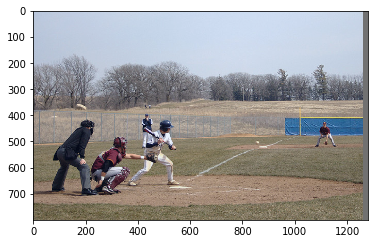

interactive(children=(IntSlider(value=4, description='c', max=9), Output()), _dom_classes=('widget-interact',)…

In [2]:
filename_id = 488   # 300784
sample_id = data_loader.dataset.datasets[1].ids.index(filename_id)
sample_id += len(data_loader.dataset.datasets[0].ids)

index = [sample_id]
images, targets, _ = dataset_fetcher.fetch(index)

images = images.to(device)
targets = [target.to(device) for target in targets]


plt.figure(figsize=(6,4))
# plt.figure(figsize=(12,8))
img_show = images.tensors[0, [2,1,0]].permute(1,2,0).detach().cpu().numpy()
img_show = (img_show - img_show.min())/(img_show.max() - img_show.min())
plt.imshow(img_show)

target_0 = targets[0]
target_0_masks = target_0.get_field('masks').get_mask_tensor()

@interact(c=(0, len(target_0_masks)-1))
def show_target_masks(c):
    plt.figure(figsize=(6,4))
#     plt.figure(figsize=(12,8))
    plt.imshow(target_0_masks[c].detach().cpu().numpy())

# Forward

In [3]:
self = model

x_img = images.tensors     # image.tensors
xs_r50 = self.r50(x_img)

xs_r50.append(self.res_layer_5(xs_r50[-1]))
xs_r50.append(self.res_layer_6(xs_r50[-1]))


N, _, img_size_h, img_size_w = x_img.shape
device = x_img.device
level_sizes = [tuple(f.shape[-2:]) for f in xs_r50[::-1]]


losses = {}
losses_0 = []
losses_1 = []
i = 0

self.log_dict={}
InstancePyramid.inst_count = 0
curr_level = 0
x_curr = xs_r50[-1]
init_pos = torch.nonzero(torch.ones_like(x_curr[0][0]))
inst_pyramids = [InstancePyramid(pos, curr_level, level_sizes) for pos in init_pos]
self.compute_mask(curr_level, x_curr[[i]], inst_pyramids, True)
self.log_dict.update({'pyr_num_l0': len(inst_pyramids)})
if self.training:
    target_levels = self._init_target((img_size_h, img_size_w ), device, targets[i])
    target_support_pyramids_0 = [[] for k in range(target_levels[7].shape[1])]
    # 统计 target 匹配
    self.match_target(0, inst_pyramids, target_levels, target_support_pyramids_0)

    loss_0 = self.compute_loss(0, inst_pyramids, target_levels, target_support_pyramids_0)
    losses_0.append(loss_0)
    
curr_level = 1
x_curr = xs_r50[-2]
self.compute_mask(curr_level, x_curr[[i]], inst_pyramids)
# TODO: 考虑其他的new_masks计算方法，比如说 multi target cross entropy loss 中的单一channel
new_masks_minus = torch.cat([i_p.get_mask(curr_level)[:,[1]] - i_p.get_mask(curr_level)[:,[0]] for i_p in inst_pyramids], dim=1)
new_masks_softmax = F.softmax(new_masks_minus,dim=1)
# avg_sharing = 1.0 / len(inst_pyramids)
# num_pixels = int(new_masks_softmax.shape[-1]*new_masks_softmax.shape[-2])
max_topk = new_masks_softmax.max(dim=1)[0].view(-1).topk(8, largest=False)[0][-1].item()
pending_thresh = max(0.02, max_topk)
new_pos = torch.nonzero(new_masks_softmax[0].max(dim=0)[0] < pending_thresh)
new_occupy = 1.0*len(new_pos) / x_curr.shape[-2] / x_curr.shape[-1]
if new_occupy > 0.5 or len(new_pos) <8-1:
    print('new_occupy:{}| len(new_pos):{}'.format(new_occupy, len(new_pos)))
new_pyramids = [InstancePyramid(pos, curr_level, level_sizes) for pos in new_pos]
self.compute_mask(curr_level, x_curr[[i]], new_pyramids, True)

merit_pyramids_idx = new_masks_softmax.topk(3, dim=1)[1].unique()
merit_pyramids = [inst_pyramids[i] for i in range(len(inst_pyramids)) if i in merit_pyramids_idx]
inst_pyramids = merit_pyramids + new_pyramids
self.log_dict.update({'pyr_num_l1': len(inst_pyramids)})
if self.training:
    self.match_target(1, new_pyramids, target_levels, target_support_pyramids_0)
    loss_1 = self.compute_loss(1, inst_pyramids, target_levels, target_support_pyramids_0)
    losses_1.append(loss_1)


In [4]:
# pyr view
level = 1
pyridxs_with_target = [i for i in range(len(inst_pyramids)) if inst_pyramids[i].target_idx]
target_idxs_matched = [inst_pyramids[pyridx].target_idx for pyridx in pyridxs_with_target]
all_targets_this_level = target_levels[7-level][0].detach().cpu()
# valid_targets_this_level = [t for t in target_levels[7-level][0].detach().cpu() if t.sum()]
print(all_targets_this_level.shape)
@interact(i=(0,len(inst_pyramids)-1))
def show_pyramids(i):
    pyr = inst_pyramids[i]
    init_size = pyr.level_sizes[pyr.init_level]
    req_size = pyr.level_sizes[level]
    print("pyr's init level:", pyr.init_level, '\t\t|init_size:', init_size, '\t\t|req_level:', level, '\t\t\t|req_level_size:', req_size)
    
    orignal_pos = tuple(pyr.pos.tolist())
    level_pos = pyr.get_root_level_pos(level)
    print("pyr's orignal_pos:", orignal_pos, '\t|req_level_pos:', level_pos, '\t|orignal_pos %:', \
          (round(orignal_pos[0]/init_size[0], 5), round(orignal_pos[1]/init_size[1], 5)), '\t|req_pos %:', \
          (round(level_pos[0]/req_size[0], 5), round(level_pos[1]/req_size[1], 5)))

    level_mask = pyr.get_mask(level)[0].max(0)[1].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(level_mask)
    plt.scatter(level_pos[1], level_pos[0], c='w')
    print('pyr.target_idx:', pyr.target_idx, '\t\t|pyridxs_with_target:', pyridxs_with_target, '|\t\ttarget_idxs_matched:', target_idxs_matched)
    if pyr.target_idx:
        target_mask = all_targets_this_level[pyr.target_idx].numpy()
        plt.figure(figsize=(6,4))
        plt.imshow(target_mask)
        plt.scatter(level_pos[1], level_pos[0], c='w')
        
    

torch.Size([10, 13, 20])


interactive(children=(IntSlider(value=37, description='i', max=75), Output()), _dom_classes=('widget-interact'…

In [110]:
target_idxs_matched

[1, 1, 4]

## 为什么 target 0 没有匹配到 pyramid

In [5]:
# target view
valid_targets_this_level = [t for t in target_levels[7-level][0].detach().cpu() if t.sum()]
valid_target_idxs = [i for i in range(len(target_levels[7-level][0])) if target_levels[7-level][0, i].detach().cpu().sum()]
print('all target idxs:', [i for i in range(len(all_targets_this_level))])
print('valid target idxs in this level:', valid_target_idxs)
print('matched target idxs:', target_idxs_matched)
print('missed target idxs:', [idx for idx in valid_target_idxs if idx not in target_idxs_matched])
@interact(i=(0,len(valid_target_idxs)-1))
def show_pyramids(i):
    print('target idxs:', valid_target_idxs[i])
    target_mask = all_targets_this_level[valid_target_idxs[i]].numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(target_mask)
    target_l0_mask = target_levels[7][0, valid_target_idxs[i]].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(target_l0_mask)

all target idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
valid target idxs in this level: [0, 1, 2, 4, 5, 8]
matched target idxs: [4, 1, 1]
missed target idxs: [0, 2, 5, 8]


interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [62]:

@interact(i=(0,len(inst_pyramids)-1))
def show_pyramids(i):
    pyr = inst_pyramids[i]
    pyr_mask_l0 = pyr.get_mask(1)[0].max(0)[1].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(pyr_mask_l0)
    
    init_size = pyr.level_sizes[pyr.init_level]
    
    
    
    pos_1 = pyr.get_root_level_pos(1)
    shape_x, shape_y = pyr_mask_l0.shape[0], pyr_mask_l0.shape[1]
    print(pyr.pos.tolist(), init_size, (pyr.pos[0].cpu().item()/init_size[0], pyr.pos[1].cpu().item()/init_size[1]))
    print(pos_1, (shape_x, shape_y), (pos_1[0]/shape_x, pos_1[1]/shape_y))
    print(pyr.init_level, init_size, pyr.level_sizes[1])
    
    
    plt.scatter(pos_1[1], pos_1[0], c='w')
    

interactive(children=(IntSlider(value=38, description='i', max=76), Output()), _dom_classes=('widget-interact'…

In [55]:

pyramids_with_targets = [p for p in inst_pyramids if p.target_idx]
p_idx_with_target = [i for i in range(len(inst_pyramids)) if inst_pyramids[i].target_idx]
@interact(i=(0,len(pyramids_with_targets)-1))
def show_pyramids(i):
    pyr = pyramids_with_targets[i]
    pos_1 = pyr.get_root_level_pos(1)
    
    pyr_mask_0 = pyr.get_mask(0)[0][0].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(pyr_mask_0)
#     plt.scatter(pyr.pos[1].cpu(), pyr.pos[0].cpu(), c='w')
    plt.scatter(pos_1[1], pos_1[0], c='w')
    pyr_mask_1 = pyr.get_mask(0)[0][1].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(pyr_mask_1)
#     plt.scatter(pyr.pos[1].cpu(), pyr.pos[0].cpu(), c='w')
    plt.scatter(pos_1[1], pos_1[0], c='w')
    
    pyr_mask_2 = pyr.get_mask(0)[0].max(0)[1].detach().cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.imshow(pyr_mask_2)
#     plt.scatter(pyr.pos[1].cpu(), pyr.pos[0].cpu(), c='w')
    plt.scatter(pos_1[1], pos_1[0], c='w')
#     plt.figure(figsize=(6,4))
#     plt.imshow(target_levels[7][0][pyr.target_idx[0,0].item()].detach().cpu().numpy())
#     plt.scatter(pyr.pos[1].cpu(), pyr.pos[0].cpu(), c='w')
    

interactive(children=(IntSlider(value=1, description='i', max=2), Output()), _dom_classes=('widget-interact',)…